# Wildfire Prediction Tool

## This tool utilizes the Random Forest algortihm to predict the impact of wildfires in counties of California based on past data.

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from urllib.request import urlopen
import geopandas as gpd
import json
import requests
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from ipywidgets import interact
import ipywidgets as widgets
import numpy as np
import panel as pn
import warnings
warnings.filterwarnings('ignore')
import logging
import datetime
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Output, Dropdown
pn.extension()
from ipywidgets import interactive_output, IntSlider
from ipywidgets import Dropdown
df = pd.read_csv('California_Fire_Incidents.csv')
import pkg_resources
import types

In [183]:
df = df[['AcresBurned', 'ArchiveYear', 'Counties','CountyIds','Name','Started','UniqueId']]

In [184]:
df = df.loc[(df['AcresBurned'].notna()) & (df['CountyIds'].notna()) & (df['ArchiveYear'].notna())]
df = df[df.Counties != 'Mexico']

### This dataset provides a list of wildfires in California. It includes data on the size of the fire, the year it occurred, the county it was in, the name of the wildfire, and a unique identification number. The data was collected secondarily from Kaggle.com.

In [185]:
df

,AcresBurned,ArchiveYear,Counties,CountyIds,Name,Started,UniqueId
0,257314.0,2013,Tuolumne,55,Rim Fire,2013-08-17T15:25:00Z,5fb18d4d-213f-4d83-a179-daaf11939e78
1,30274.0,2013,Los Angeles,19,Powerhouse Fire,2013-05-30T15:28:00Z,bf37805e-1cc2-4208-9972-753e47874c87
2,27531.0,2013,Riverside,33,Mountain Fire,2013-07-15T13:43:00Z,a3149fec-4d48-427c-8b2c-59e8b79d59db
3,27440.0,2013,Placer,31,American Fire,2013-08-10T16:30:00Z,8213f5c7-34fa-403b-a4bc-da2ace6e6625
4,24251.0,2013,Ventura,56,Springs Fire,2013-05-02T07:01:00Z,46731fb8-3350-4920-bdf7-910ac0eb715c
...,...,...,...,...,...,...,...
1628,10.0,2019,Butte,4,Moms Fire,2019-07-23T14:41:00Z,7955a367-99da-4047-9f69-cc60ad3208e6
1629,10.0,2019,Siskiyou,47,IronGate Fire,2019-06-16T20:33:00Z,fe63d965-9069-4a96-b9da-99d5fefdaa19
1630,10.0,2019,Butte,4,Cana Fire,2019-04-30T12:20:00Z,34abbc65-5bbe-474b-85c8-16d07bb5b503
1631,9.0,2019,Riverside,33,Eagle Fire,2019-10-10T12:08:00Z,6e93b252-99a3-4214-9921-238373b17535


In [186]:
grouped_data = df.pivot_table(index='Counties', columns='ArchiveYear', values='AcresBurned')

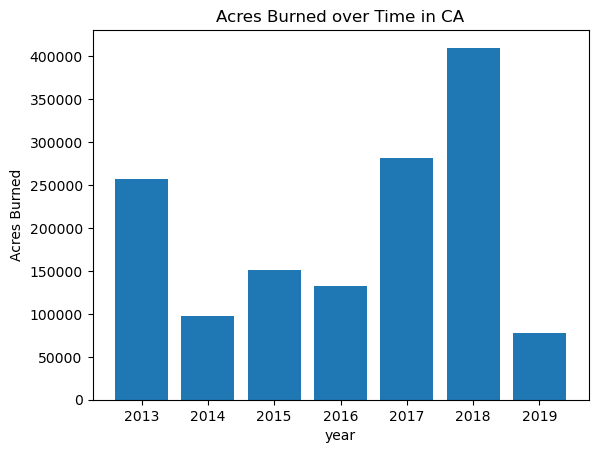

In [187]:
plt.bar(df['ArchiveYear'], df['AcresBurned'])
plt.title("Acres Burned over Time in CA")
plt.xlabel("year")
plt.ylabel("Acres Burned")
plt.show()

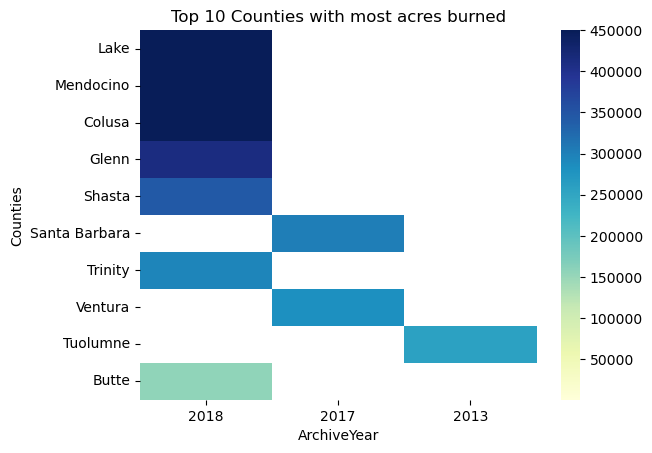

In [188]:
df3 = df.groupby(['Counties','ArchiveYear'])['AcresBurned'].sum()
df3 = df3.sort_values(ascending=False).head(10)
grouped_data = df3.unstack()
ax = plt.axes()
sns.heatmap(grouped_data, ax = ax,vmax=450000,vmin=1000,cmap='YlGnBu')
ax.set_title("Top 10 Counties with most acres burned")
plt.xlabel("ArchiveYear")
plt.ylabel("Counties")
plt.show()

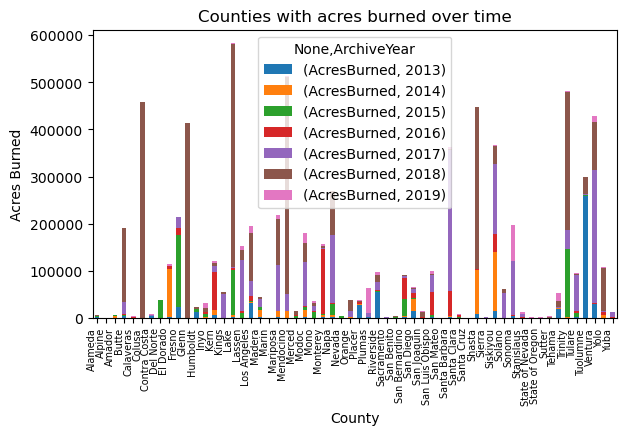

In [189]:
df3 = df.groupby(['Counties','ArchiveYear'], as_index=False).sum()
df3.set_index(['Counties','ArchiveYear']).unstack().plot(kind='bar', stacked=True)
plt.title("Counties with acres burned over time")
plt.xlabel("County")
plt.ylabel("Acres Burned")
plt.tight_layout()
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)
plt.show()

In [190]:
# read shapefile of California counties
gdf = gpd.read_file('California_County_Boundaries/cnty19_1.shp')

merged_df = pd.merge(gdf, df, left_on='COUNTY_NAM', right_on='Counties')

def map_year(Year=1):
    # filter dataframe to specific year
    year = Year
    year_df = merged_df[merged_df['ArchiveYear'] == year]

    # group by county and sum the 'AcresBurned' column
    county_acres_burned = year_df.groupby('Counties')['AcresBurned'].sum()

    # convert the index to a column again
    county_acres_burned = county_acres_burned.reset_index()

    # set the 'Counties' column as the index of the county_acres_burned DataFrame
    county_acres_burned.set_index('Counties', inplace=True)

    # merge the gdf DataFrame with the county_acres_burned DataFrame on the 'COUNTY_NAM' column
    merged_gdf = gdf.merge(county_acres_burned, left_on='COUNTY_NAM', right_index=True, how='left')

    # create map of California with counties colored according to the number of acres burned
    merged_gdf.plot(column='AcresBurned', cmap="YlOrRd",legend=True,vmax=(50000),vmin=(0))
    plt.title("      Acres Burned in California in " + str(year))

    #add a legend
    plt.legend('Acres Burned')
    plt.show()

#### Use the slider to see acres burned over time

In [191]:
year_slider = IntSlider(
    value=2013,
    min=2013,
    max=2019,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

output = interactive_output(map_year, {'Year': year_slider})
display(year_slider,output)

IntSlider(value=2013, continuous_update=False, description='Year:', max=2019, min=2013)

Output()

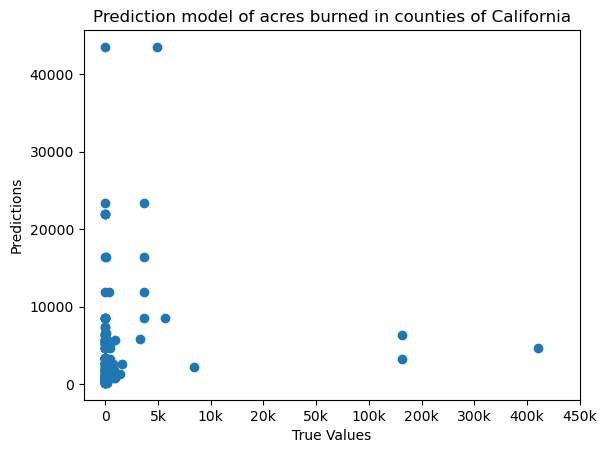

In [192]:
# Create one-hot encoded variables for the selected counties
X = pd.get_dummies(df[['Counties']])
y = df['AcresBurned']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.11, random_state=8)

# Drop the extra columns from the test data
columns_to_drop = set(X_train.columns) - set(X_test.columns)
X_test = X_test.drop(columns=columns_to_drop)

# Create an instance of RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predict the target variable using the test data
y_pred = regressor.predict(X_test)

# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.title("Prediction model of acres burned in counties of California")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000], ['0','5k' ,'10k','20k','50k', '100k','200k', '300k','400k', '450k'])
plt.show()

In [193]:
out = Output()

def County_pred(County):
    County_List = []
    County_List.clear()
    County_List.append(County)
    logging.info('Change of county in Prediction model of acres burned to ' + County_List[0])
    # Select the counties you want to include
    counties = County_List

    # Subset the dataframe to include only the selected counties and year
    df5 = df[(df['Counties'].isin(counties)) & (df['ArchiveYear'] >= 2013) & (df['ArchiveYear'] <= 2019)]

    if len(df5) < 2:
        print("Not enough data for year and county")
        return
    # Create one-hot encoded variables for the selected counties
    X = pd.get_dummies(df5[['Counties','ArchiveYear']], columns=["Counties"])
    y = df5['AcresBurned']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.11, random_state=8)

    # Create an instance of RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators=10, random_state=0)

    # Fit the model to the training data
    regressor.fit(X_train, y_train)

    # Predict the target variable using the test data
    y_pred = regressor.predict(X_test)
    # Calculate the mean squared error and R-squared score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    with out:
        clear_output(wait=True)
        print('Predicted Acres burned:', y_pred[-1])

#### Pick a county to predict it's impact of a wildfire

In [194]:
out = Output()
county_dropdown = Dropdown(options=['Alameda','Alpine','Amador','Butte','Calaveras','Colusa','Contra Costa','Del Norte','El Dorado','Fresno','Glenn','Humboldt','Imperial','Inyo','Kern','Kings','Lake','Lassen','Los Angeles','Madera','Marin','Mariposa','Mendocino','Merced','Modoc','Mono','Monterey','Napa','Nevada','Orange','Placer','Plumas','Riverside','Sacramento','San Benito','San Bernardino','San Diego','San Fransisco','San Joaquin','San Luis Obispo','San Mateo','Santa Barbara','Santa Clara','Santa Cruz','Shasta','Sierra','Siskiyou','Solano','Sonoma','Stanislaus'],value='Alameda',description='County:',)
def on_change(change):
    with out:
        clear_output(wait=True)
        County_pred(change.new)
county_dropdown.observe(on_change, 'value')
display(county_dropdown, out)

Dropdown(description='County:', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contr…

Output()